### Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

### Camera Caliberation

As the first step, we need to caliberate the camera to make sure the images are not distorted. Thus, the OpenCV function `findChessboardCorners()` is used to find the corners of the several caliberation images. These points are then compared with object points which are corners of an ideal chess board. Then, the function `cv2.calibrateCamera` is used to calculate the caliberation matrix.

The caliberation matrix is then used to caliberate all the camera images. Below is an example of caliberation of a chessboard image.

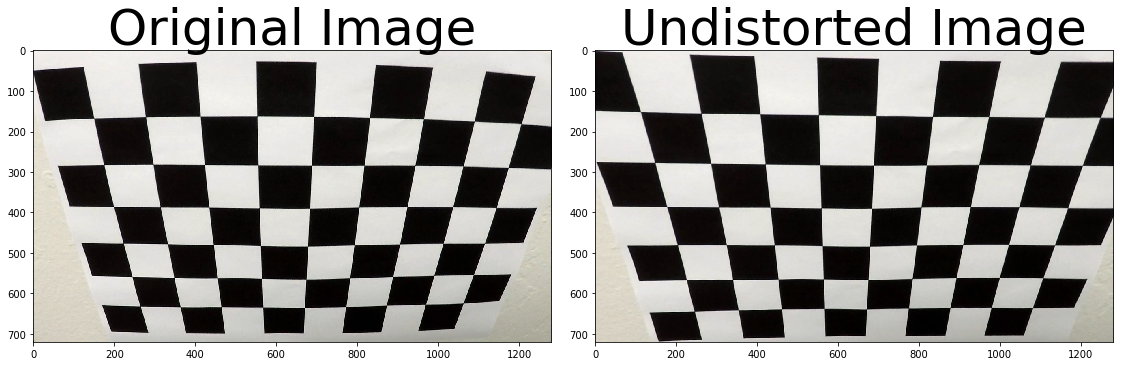

In [2]:
def caliberation():
    objpoints=[]
    imgpoints=[]

    nx=9
    ny=6

    objp=np.zeros((nx*ny,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    images = glob.glob('camera_cal/calibration*.jpg')

    for fname in images:
        img=mpimg.imread(fname)
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners=cv2.findChessboardCorners(gray,(nx,ny),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #img=cv2.drawChessboardCorners(img,(6,8), corners, ret)
            #plt.imshow(img)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    
    return mtx,dist

mtx, dist = caliberation()
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#undistorted=caliberation(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


Now, the same caliberation matrix can be used to undistort the test images as well.
Below is an example of an undisotrted test image.

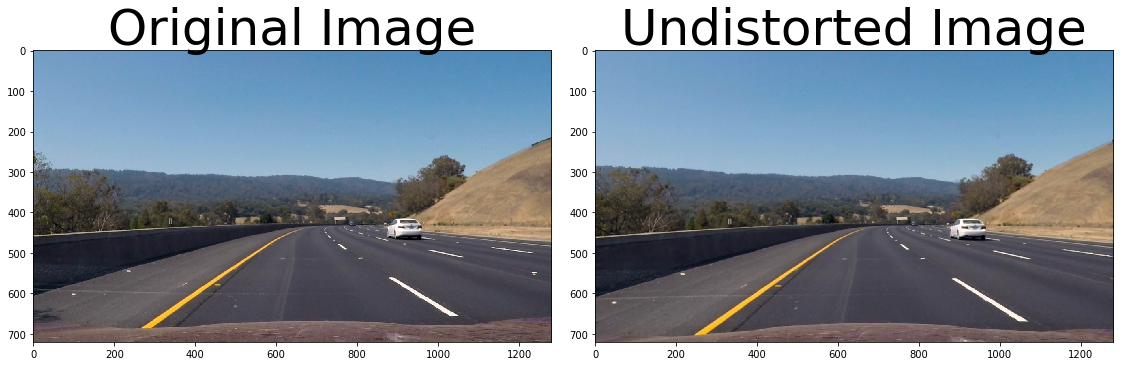

In [3]:
img = mpimg.imread('test_images/test3.jpg')
img_shape=img.shape
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

First, a perspective transform is used to get a birds eye view of the lane lines. By transforming the curved lane lines  intro semi-parallel lines, the curvature can be more easily calculated. For this purpose, the `cv2.getPerspectiveTransform` function is used with a set of source and destination points. The inverse transform matrix is also calculated for later when the image is transformed back to original view.

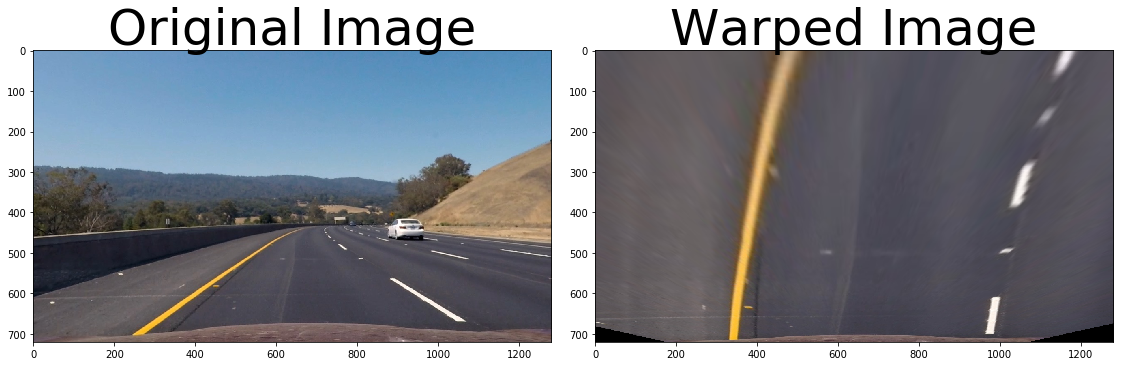

In [4]:
def get_perspective(img):
    src = np.float32([[(585,460),(203,720),(1127,720),(695,460)]])
    dst=np.float32([[(320,0),(320,720),(960,720),(960,0)]])
    image_shape=img.shape
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = (image_shape[1], image_shape[0])
    view = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    return M_inv, view

M_inv, view = get_perspective(undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(view, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### Sobel Threshold
Here, absolute Sobel threshold masking on the x axis is defined on the bird's eye view image.

In [5]:
def abs_sobel_thresh(img,orient='x',thresh_min=0,thresh_max=255):
    if orient=='x':
        sobel=cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel=cv2.Sobel(img, cv2.CV_64F, 0, 1)
    abs_sobelx = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

##### Color Masking
Color masking on the white and yellow colors is also performed in the HSV color space. The color masks for white and yellow colors are added together, the results are converted to grayscale and the nonzero values are outputted in a binary format.

In [6]:
def color_mask(img):
    #Thresholds
    yellow_lower_filter = np.array([0, 100, 100])
    yellow_upper_filter = np.array([80, 255, 255])

    white_lower_filter = np.array([200, 200, 200])
    white_upper_filter = np.array([255, 255, 255])

    #yellow masking
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, yellow_lower_filter, yellow_upper_filter)
    yellow_mask = cv2.bitwise_and(img, img, mask=yellow_mask)

    #white masking
    rgb = img
    white_mask = cv2.inRange(rgb, white_lower_filter, white_upper_filter)
    white_mask = cv2.bitwise_and(img, img, mask=white_mask)

    #combined masks
    combined_mask = cv2.addWeighted(white_mask, 1., yellow_mask, 1., 0.)

    #convert to binary image
    gray_mask = cv2.cvtColor(combined_mask, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray_mask)
    binary[(gray_mask > 0)] = 1
    return binary
    #return yellow_mask, white_mask, binary



Next, sobel thresholding mask is performed on the light and saturation channels of HLS olor space and combined together with "or" operatior.
The result is then combined together with the output of color masking with "or" operator as well. The final output is depicted below.

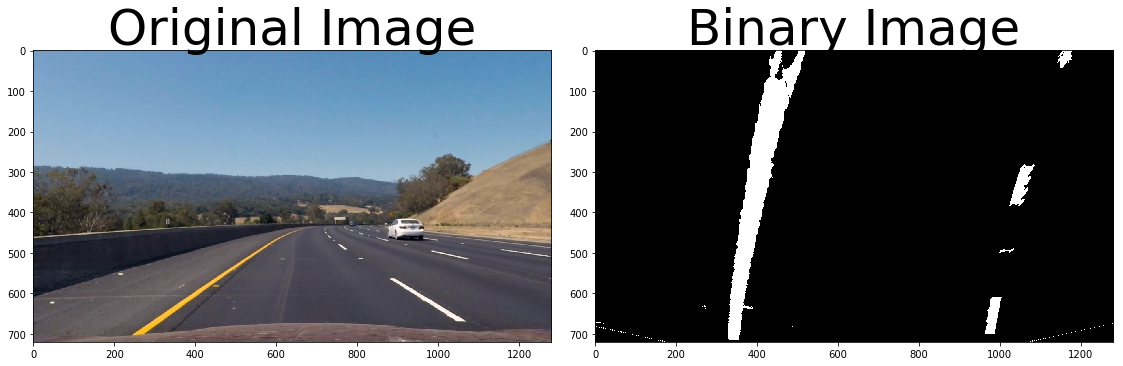

In [7]:
hls = cv2.cvtColor(view,cv2.COLOR_RGB2HLS)
h=hls[:,:,0]
l=hls[:,:,1]
s=hls[:,:,2]
sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh_min=50, thresh_max=225)
sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh_min=50, thresh_max=225)
combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)
color_binary=color_mask(view)
final_mask = cv2.bitwise_or(combined_sobel,color_binary)    
binary_warped = np.copy(final_mask)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Finding Lane Lines
Isince the result image is a binary bird's eye view, the position of lane lines is where most of the pixels are nonzero. Such position can be determined using a histogram as below;

356 982


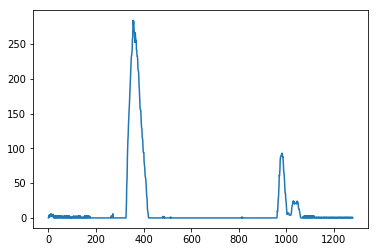

In [8]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base, rightx_base)
plt.plot(histogram)

#### Finding Lane Lines

Now, a sliding window search is used to find the "hot" pixels corresponding to the lane lines. This method is visualized as below:

(720, 0)

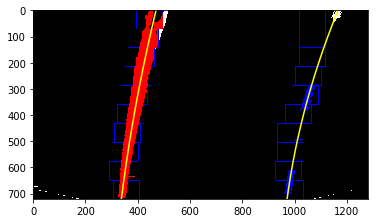

In [9]:
warped=binary_warped

out_img = np.dstack((warped, warped, warped))*255

non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = leftx_base - window_half_width
    left_x_max = leftx_base + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = rightx_base - window_half_width
    right_x_max = rightx_base + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

After finding the position of the lane lines with a blind search, in the next frame the search can be done in the vicinity of the already found lanes. The output is visualized below:

(720, 0)

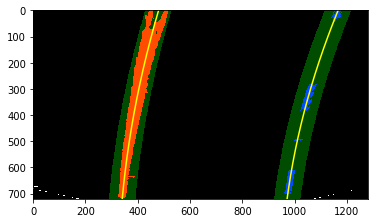

In [10]:


margin = 50
out_img = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

window_img = np.zeros_like(out_img)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0],0)

#### Curvature Measurement

In this section, a second order polynomial is fitted to the left and right lane lines in order to determine their curvature. Then the two curvautres are averaged to determine the lane curvature.
In addition, lane center and the deviation from the lane center are also calculated here.

In [11]:
img_size = (img.shape[1], img.shape[0])
def measure_radius_of_curvature(x_values):
    img_size = (img.shape[1], img.shape[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = measure_radius_of_curvature(left_x_predictions)
right_curve_rad = measure_radius_of_curvature(right_x_predictions)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(img_size[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)

Radius of curvature: 1016.02 m
Center offset: 0.09 m


### Proposed Pipeline:

In this step, all the previously introduced steps are combined into a pipeline.

In [12]:
def pipeline(img):
    
    img_size = (img.shape[1], img.shape[0])
    img_shape=img.shape
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    M_inv, view=get_perspective(undistorted)
    hls = cv2.cvtColor(view,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    sobelx_light_mask = abs_sobel_thresh(l, orient='x', thresh_min=50, thresh_max=225)
    sobelx_saturation_mask = abs_sobel_thresh(s, orient='x', thresh_min=50, thresh_max=225)
    combined_sobel = cv2.bitwise_or(sobelx_light_mask, sobelx_saturation_mask)
    color_binary=color_mask(view)
    final_mask = cv2.bitwise_or(combined_sobel,color_binary)
    binary_warped = np.copy(final_mask)
    num_rows=binary_warped.shape[0]
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img_shape[1], img_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    curverad_left = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    curverad_right = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    average_curve_rad = (curverad_left + curverad_right)/2


    # compute the offset from the center
    lane_center = (right_fitx[719] + left_fitx[719])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    
    
    
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int(average_curve_rad)), (120,140),
             cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    # Print distance from center on video
    if lane_center > 640:
        cv2.putText(result, 'Vehicle is {:.2f}(m) left of the center'.format(center_offset_mtrs), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}(m) right of the center'.format(center_offset_mtrs), (100,80),
                 cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1, color=(255,255,255), thickness = 3)
        
    #Left.count += 1
    return result

    

This pipeline can be used to detect lane lines and calculate curvature for all images. Below is an example:


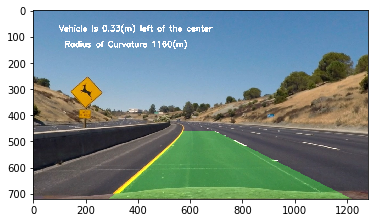

In [13]:
img = mpimg.imread('test_images/test2.jpg')
result=pipeline(img)
plt.imshow(result)

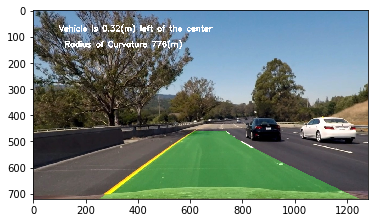

In [14]:
import os
images = os.listdir("test_images/")
for img_file in images:
    #print(img_file)
    # Skip all files starting with line.
    if img_file[0:4] == 'line':
        continue
    
    image = mpimg.imread('test_images/' + img_file)   
    
    weighted = pipeline(image)

    plt.imshow(weighted)
    #break
    mpimg.imsave('test_images/lines-' + img_file, weighted)

Now, this pipeline is implemented on the video files.

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'first_draft.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video first_draft.mp4
[MoviePy] Writing video first_draft.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:44<00:00,  5.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: first_draft.mp4 

Wall time: 3min 45s


#### Limitations:

The pipeline developed here is successful in detecting the lane line in the given condition. However, the surrounding conditions are not always this ideal. Even in the test video it can be seen that the pipeline outputs slight errors with shadows.

As a result, it can be condluded that this appraoch will not be as successful in situations where it is dark, rainy or full of shadows. 
Also, if the lane lines are faded, this pipeline will not perform properly, so it must be improved with lane line predictions using geographical and navigation information.